### Pipeline for a single spikeglx session
- Load an exctractor for visualization of the data
- Sort it using kilosort

In [1]:
%matplotlib inline

import os
import glob
import logging
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [2]:
from ceciestunepipe.file import filestructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

In [3]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-01-30 11:49:05,219 root         INFO     all modules loaded


### Session parameters and raw files

In [74]:
reload(et)


bird = 'z_w12m7_20'
all_bird_sess = et.list_sessions(bird)
all_bird_sess

['20201105', '20201106', '20201104']

In [75]:
sess_par = {'bird': 'z_w12m7_20',
           'sess': '20201104',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['raw']

In [76]:
et

<module 'ceciestunepipe.file.filestructure' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/file/filestructure.py'>

In [77]:
exp_struct['folders']['tmp']

'/scratch/earneodo/tmp/tmp'

In [78]:
print(os.environ['TMP'])

/scratch/earneodo/tmp/tmp


In [7]:
sess_epochs = sglu.list_sgl_epochs(sess_par)
sess_epochs

2021-01-30 11:49:07,822 ceciestunepipe.util.sglxutil INFO     {'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20', 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104', 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104', 'derived': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/derived/20201104', 'tmp': '/scratch/earneodo/tmp/tmp', 'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104', 'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104'}, 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/params.json', 'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf', 'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json', 'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/stream.

['20201104_alles',
 '2500r250a_3500_dir_g0',
 '2500r250a_3500_dir_g1',
 '2500r250a_3500_dir_g2']

In [79]:
### pick a session
reload(sglu)
epoch = sess_epochs[-1] # g2 is the shortest

exp_struct = sglu.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['raw'])

In [80]:
sgl_folders

{'nidq': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2',
 'imec_0': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2/2500r250a_3500_dir_g2_imec0'}

In [81]:
sgl_files

{'nidq': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2/2500r250a_3500_dir_g2_t0.nidq.meta'],
 'lf_0': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2/2500r250a_3500_dir_g2_imec0/2500r250a_3500_dir_g2_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2/2500r250a_3500_dir_g2_imec0/2500r250a_3500_dir_g2_t0.imec0.ap.meta']}

In [82]:
import pandas as pd

In [83]:
files_pd = pd.DataFrame(sgl_files)

In [84]:
files_pd

,nidq,lf_0,ap_0
0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...


In [85]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}


#probe_data_folder = sgl_folder['imec'][probe_id]


### view the nidaq data

In [15]:
run_recordings['nidq']

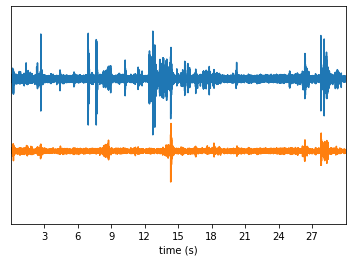

In [16]:
w_ts = sw.plot_timeseries(run_recordings['nidq'], channel_ids=[0, 7], trange=[0,30])

In [17]:
nidq_ttl = run_recordings['nidq'].get_ttl_events()

2021-01-30 11:49:11,388 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [18]:
run_recordings['lf_0']._raw.shape

(385, 334007)

In [19]:
syn_ch_arr = run_recordings['lf_0']._raw[-1, :]

np.mean(syn_ch_arr)

32.039951258506555

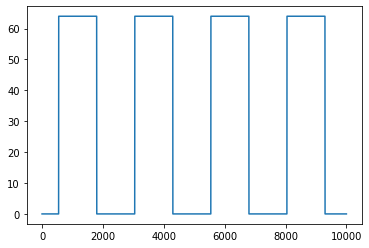

In [20]:
plt.plot(syn_ch_arr[:10000])

In [21]:
run_recordings['ap_0']._meta

{'acqApLfSy': '384,384,1',
 'appVersion': '20200520',
 'fileCreateTime': '2020-11-04T18:02:34',
 'fileName': 'D:/experiment/raw_data/z_w12m7_20/20201104/2500r250a_3500_dir_g2/2500r250a_3500_dir_g2_imec0/2500r250a_3500_dir_g2_t0.imec0.ap.bin',
 'fileSHA1': 'FFCFAFF169294CA1BED6B39D5C7940B1CC59F923',
 'fileSizeBytes': '3086220060',
 'fileTimeSecs': '133.6027459520931',
 'firstSample': '294100386',
 'gateMode': 'Immediate',
 'imAiRangeMax': '0.6',
 'imAiRangeMin': '-0.6',
 'imCalibrated': 'true',
 'imDatApi': '1.20',
 'imDatBs_fw': '1.1.123',
 'imDatBsc_fw': '1.0.151',
 'imDatBsc_hw': '5.1',
 'imDatBsc_pn': 'NP2_HS_30',
 'imDatBsc_sn': '567',
 'imDatFx_hw': '1.2',
 'imDatFx_pn': 'NP2_FLEX_0',
 'imDatHs_fw': '5.2',
 'imDatHs_pn': 'NP2_HS_30',
 'imDatHs_sn': '1807',
 'imDatPrb_pn': 'PRB_1_4_0480_1',
 'imDatPrb_port': '4',
 'imDatPrb_slot': '2',
 'imDatPrb_sn': '19108322052',
 'imDatPrb_type': '0',
 'imLEDEnable': 'false',
 'imMaxInt': '512',
 'imRoFile': 'D:/experiment/raw_data/audio_test/l

#### file creation time

In [22]:
import time
import datetime

# c_time = time.ctime(os.path.getmtime(bin_file_path))
# c_time

# timestamp = os.path.getmtime(bin_file_path)
# datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]

def get_creation_time(sglx_recording):
    bin_file_path = sglx_recording._npxfile
    
    ## file creation time is volatile (esp after copying in windows), 
    ## compute the start form the last modified and file duration
    ## this kind of sucks, but it's the best we have
    bin_end_tstamp = os.path.getmtime(bin_file_path)
    bin_end_str = datetime.datetime.fromtimestamp(bin_end_tstamp).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    logger.info('file end {}'.format(bin_end_str))
    
    bin_start_tstamp = bin_end_tstamp - float(sglx_recording._meta['fileTimeSecs'])
    bin_start_str = datetime.datetime.fromtimestamp(bin_start_tstamp).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    logger.info('file start {}'.format(bin_start_str))
    
    return bin_start_tstamp

get_creation_time(run_recordings['ap_0'])
    

2021-01-30 11:49:13,229 root         INFO     file end 2020-11-04 18:04:47.912
2021-01-30 11:49:13,231 root         INFO     file start 2020-11-04 18:02:34.309


1604541754.3097029

## The digital and sync channel in the recording
- using the new methods in my version of readSGLX, spikeglxrecordingextractor

2021-01-30 11:49:13,789 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


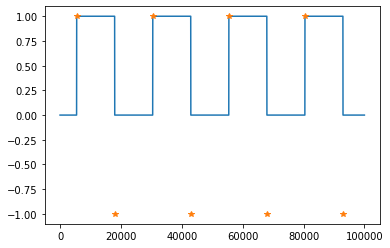

In [23]:
### the digital chan and the syn extraction of the nidq rec

nidq_syn = rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, 100000, 0, [0], run_recordings['nidq']._meta)
nidq_syn_ttl = run_recordings['nidq'].get_ttl_events(channel_id=0, end_frame=100000)

plt.plot(nidq_syn.flatten())
plt.plot(*nidq_syn_ttl, '*')

In [24]:
nidq_syn_ttl

(array([ 5435, 17935, 30435, 42935, 55435, 67935, 80435, 92934]),
 array([ 1, -1,  1, -1,  1, -1,  1, -1]))

2021-01-30 11:49:14,447 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 11:49:14,461 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 31.02592
2021-01-30 11:49:14,462 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 11:49:14,463 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 11:49:14,464 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 31.02592


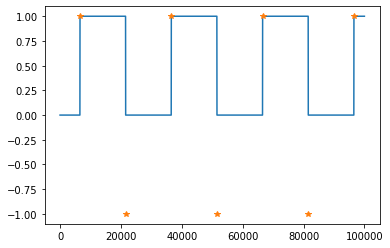

In [25]:
### the digital chan and the syn extraction of the nidq rec
ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, 100000, 0, [0], run_recordings['ap_0']._meta)
ap_syn_ttl = run_recordings['ap_0'].get_ttl_events(end_frame=100000)

plt.plot(ap_syn.flatten())
plt.plot(*ap_syn_ttl, '*')

In [26]:
run_recordings['ap_0'].get_traces()

memmap([[  9,   4,  14, ...,  12,  10,  16],
        [  9,   1,  -9, ...,   5,   3,   4],
        [ -3, -11, -15, ...,  -6, -11, -13],
        ...,
        [ 39,  37,  37, ...,   2,  -4,   3],
        [ 55,  55,  55, ...,  15,  15,  14],
        [ 31,  31,  30, ...,  -4,  -6,  -4]], dtype=int16)

In [27]:
ttl_arr = np.array(ap_syn_ttl)

In [28]:
ttl_arr[1]==-1

array([False,  True, False,  True, False,  True, False])

In [29]:
np.diff(ttl_arr[0, ttl_arr[1]==-1])

array([30000, 30000])

### The time syncronization

In [30]:
# t_0 is n/s_f (measured s_f)
# t_prime is interpolation to a t_ref (the nidaq, for instance, but it should be the one with the highest s_f)

In [31]:
def compute_sf(ttl: tuple) -> np.array:
    ttl_arr = np.array(ttl)
    
    # get all the diffs betwenn edge ups and edge donws
    all_diff_arr = np.concatenate([np.diff(ttl_arr[0, ttl_arr[1]==j]) for j in [-1, 1]])
    
    return all_diff_arr

np.mean(compute_sf(ap_syn_ttl))

30000.0

In [32]:
compute_sf(nidq_syn_ttl)

array([25000, 25000, 24999, 25000, 25000, 25000])

#### use the imec af as a pattern

In [33]:
signal = 'ap_0'

syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 120000, 0, [0], run_recordings[signal]._meta)

traces = run_recordings[signal].get_traces(end_frame=120000)
n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=120000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-01-30 11:49:22,284 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 11:49:22,293 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00213333333333
2021-01-30 11:49:22,296 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 11:49:22,297 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 11:49:22,299 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.00213333333333


In [34]:
ttl_edge_tuple_pattern = ttl_edge_tuple
s_f_pattern = s_f
t_pattern = t_0
t_pattern_edge = t_0_edge
syn_stream_pattern = syn_stream

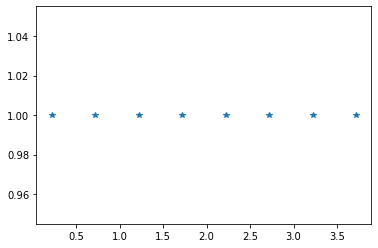

In [35]:
plt.plot(t_0_edge, np.ones_like(t_0_edge), '*')

In [36]:
s_f_pattern, t_pattern, ttl_edge_tuple_pattern = run_recordings[signal].get_effective_sf()

In [37]:
ttl_edge_tuple_pattern[0].shape

(8,)

#### fit the nidaq to the pattern

In [38]:
signal = 'nidq'
traces = run_recordings[signal].get_traces(end_frame=100000)
syn_stream = rsgl.ExtractDigital(run_recordings[signal]._raw, 0, 100000, 0, [0], run_recordings[signal]._meta)

n_t = traces.shape[-1]

ttl_edge_tuple = run_recordings[signal].get_ttl_events(end_frame=100000)

s_f = np.mean(compute_sf(ttl_edge_tuple))


t_0 = np.arange(n_t)/s_f

t_0_edge = t_0[ttl_edge_tuple[0]]

2021-01-30 11:49:25,647 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [39]:
run_recordings[signal].syn_to_pattern(t_pattern, ttl_edge_tuple_pattern)

array([5.21733333e-05, 9.21760000e-05, 1.32178667e-04, ...,
       1.33619071e+02, 1.33619111e+02, 1.33619151e+02])

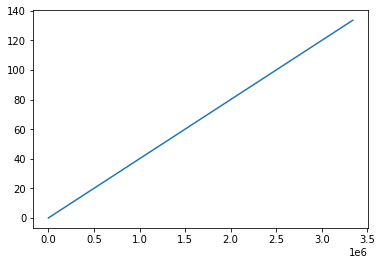

In [40]:
plt.plot(run_recordings[signal]._t_prime)

### make the time conversions using the syn_to_sgl_rec_exctractor method

In [41]:
run_recordings['lf_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-01-30 11:49:30,062 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 11:49:30,064 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 11:49:38,474 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.042250674762315
2021-01-30 11:49:38,550 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 11:49:38,551 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 11:49:38,555 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.0399

In [42]:
run_recordings['nidq'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-01-30 11:49:38,573 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 11:49:38,574 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 11:49:38,624 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.042250674762315
2021-01-30 11:49:38,697 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0


In [43]:
run_recordings['ap_0'].syn_to_sgl_rec_exctractor(run_recordings['ap_0'], force_ttl=True)

2021-01-30 11:49:38,855 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 11:49:38,855 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 11:49:38,906 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.042250674762315
2021-01-30 11:49:38,977 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2021-01-30 11:49:38,978 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-01-30 11:49:39,027 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Thresholf for logical hi is 32.0422

### Test the sync

##### plot all three times
should see different slopes, same end point

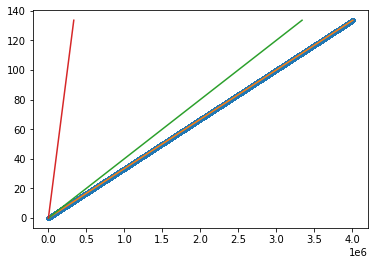

In [40]:
plt.plot(run_recordings['ap_0']._t_0, '.')
plt.plot(run_recordings['ap_0']._t_prime)
plt.plot(run_recordings['nidq']._t_prime)
plt.plot(run_recordings['lf_0']._t_prime)

In [41]:
run_recordings['lf_0']._t_prime[-1]

133.60224073604007

In [42]:
run_recordings['ap_0']._t_prime[-1]

133.60253305596652

In [43]:
run_recordings['nidq']._t_prime[-1]

133.6015515110232

In [44]:
raise KeyboardInterrupt

KeyboardInterrupt: 

### plot the square syn signals in the three different timescales

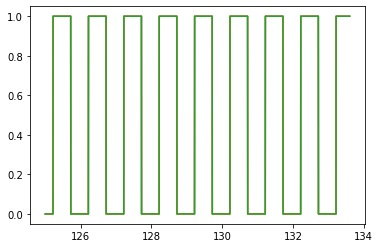

In [47]:
sig = 'lf_0'
t_start_plot = 125

t_plot = run_recordings[sig]._t_prime > t_start_plot
plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

sig = 'ap_0'
t_plot = run_recordings[sig]._t_prime > t_start_plot
plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

sig = 'nidq'
t_plot = run_recordings[sig]._t_prime > t_start_plot
plt.plot(run_recordings[sig]._t_prime[t_plot], run_recordings[sig]._dig[t_plot])

### The sorting

In [48]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhyRecordingExtractor,
 spikeextractors.extractors.maxoneextractors.maxoneextractors.MaxOneRecordingExtractor,
 spikeextractors.extractors.mea1kextractors.mea1kextractors.Mea1kRecordingExtractor,
 spikeextractors.extractors.mcsh5recordingextractor.mcsh5rec

##### pick one ap stream, view it after running some of the toolkits

In [44]:
ap_extractor = run_recordings['ap_0']

###### view it raw

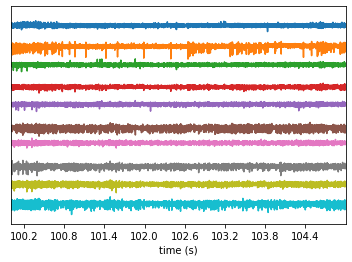

In [50]:
sw.plot_timeseries(ap_extractor, channel_ids=range(40, 50), trange=[100,105])

###### filtered

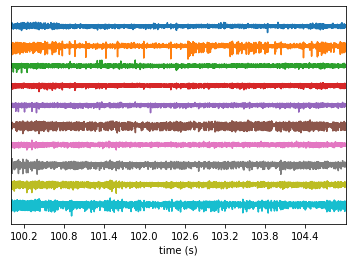

In [51]:
ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[100,105])

###### cmr

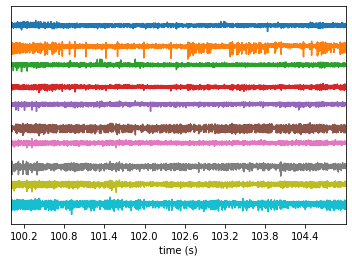

In [52]:
ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(40, 50), trange=[100,105])

In [45]:
exp_struct['folders']

{'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/2500r250a_3500_dir_g2',
 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/2500r250a_3500_dir_g2',
 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/2500r250a_3500_dir_g2',
 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g2',
 'derived': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/derived/20201104/2500r250a_3500_dir_g2',
 'tmp': '/scratch/earneodo/tmp/tmp/2500r250a_3500_dir_g2',
 'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104/2500r250a_3500_dir_g2',
 'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g2'}

In [47]:
import logging
import tempfile
import multiprocessing
import pickle
import os

N_JOBS_MAX = multiprocessing.cpu_count()

In [48]:
### this is already in sgle.expstruct

def run_spikesort(recording_extractor: se.RecordingExtractor, 
                  logger: logging.Logger,
                  sort_pickle_path: str,
                  tmp_dir: str, 
                  grouping_property: str=None,
                 sorting_method: str='kilosort2',
                 n_jobs_bin: int=N_JOBS_MAX,
                 chunk_mb: int=4096, restrict_to_gpu=None,
                 **sort_kwargs):

    logger.info("Grouping property: {}".format(grouping_property))
    logger.info("sorting method: {}".format(sorting_method))
    
    # try:
    if sorting_method == "kilosort2":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks2')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)

            
        sort = ss.run_kilosort2(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            parallel=True,
            verbose=True,
            grouping_property=grouping_property,
            chunk_mb=chunk_mb,
            n_jobs_bin=n_jobs_bin,
            **sort_kwargs
        )
        
    else:
        raise NotImplementedError('Only know how to sort kilosort2 for now, \
                                        will deal with {} later'.format(sorting_method))
        
    logger.info('done sorting')
    
    # save sort
    logger.info("Saving sort {}".format(sort_pickle_path))
    with open(sort_pickle_path, "wb") as output:
        pickle.dump(sort, output, pickle.HIGHEST_PROTOCOL)
    logger.info("Sorting output saved to {}".format(sort_pickle_path))
      
    # get templates and max channel
    logger.info("Getting templates")
    templates = st.postprocessing.get_unit_templates(
        recording_extractor,
        sort,
        max_spikes_per_unit=200,
        save_as_property=True,
        verbose=True,
        n_jobs=n_jobs_bin,
        grouping_property=grouping_property,
    )
    
    logger.info("Getting main channel")
    max_chan = st.postprocessing.get_unit_max_channels(
        recording_extractor, 
        sort, 
        save_as_property=True, 
        verbose=True, 
        n_jobs=n_jobs_bin
    )   
    
    # save sort again with all that processed data
    sort_temp_pickle_path = sort_pickle_path + '.dump.pkl'
    logger.info("Saving sort {}".format(sort_temp_pickle_path))
    sort.dump_to_pickle(sort_temp_pickle_path)
    
    return sort

In [49]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'n_chan': n_chan,
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [69]:
default_ks2_params = ss.Kilosort2Sorter.default_params()
default_ks2_params

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

##### manually enter ksort params

In [57]:
ks2_params = {'minFR': 0.01,
             'minfr_goodchannels': 0.01}

In [72]:
tmp_loc = exp_struct['folders']['ksort']


In [73]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle')
sort = run_spikesort(ap_extractor, logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, **ks2_params)

2021-01-28 08:08:44,837 root         INFO     Grouping property: None
2021-01-28 08:08:44,839 root         INFO     sorting method: kilosort2
2021-01-28 08:08:44,839 root         INFO     Sorting tmp dir /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g2/tmp_ks2
2021-01-28 08:08:44,840 root         INFO     Will set visible gpu devices 1


kilosort2 run time 166.58s


2021-01-28 08:11:49,209 root         INFO     done sorting
2021-01-28 08:11:49,212 root         INFO     Saving sort /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g2/sort_ks2.pickle
2021-01-28 08:11:49,729 root         INFO     Sorting output saved to /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g2/sort_ks2.pickle
2021-01-28 08:11:49,767 root         INFO     Getting templates


Number of chunks: 198 - Number of jobs: 32


2021-01-28 08:22:06,221 root         INFO     Getting main channel
2021-01-28 08:22:06,456 root         INFO     Saving sort /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/2500r250a_3500_dir_g2/sort_ks2.pickle.dump.pkl


In [78]:
sort.get_epoch_names()

[]

## Try with sglexp
make a pandas dataframe to keep track of epochs (folders), runs within each session, caryying the recording extractors

In [50]:
from ceciestunepipe.util import sglxexp as sgle

In [51]:
reload(sgle)
epoch_pd = sgle.make_sgl_epoch_dict(sess_par, sess_epochs[1])

In [52]:
epoch_pd

,bird,sess,epoch,run,nidq,lf_0,ap_0,rec-nidq,rec-lf_0,rec-ap_0
0,z_w12m7_20,20201104,2500r250a_3500_dir_g0,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...


In [53]:
reload(sgle)
sess_pd = sgle.make_session_pd(sess_par)
sess_pd

2021-01-30 11:50:29,315 ceciestunepipe.util.sglxutil INFO     {'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20', 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104', 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104', 'derived': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/derived/20201104', 'tmp': '/scratch/earneodo/tmp/tmp', 'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104', 'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104'}, 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/params.json', 'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf', 'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json', 'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/stream.

,bird,sess,epoch,run,nidq,lf_0,ap_0,rec-nidq,rec-lf_0,rec-ap_0
0,z_w12m7_20,20201104,2500r250a_3500_dir_g0,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...
1,z_w12m7_20,20201104,2500r250a_3500_dir_g1,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...
2,z_w12m7_20,20201104,2500r250a_3500_dir_g2,0,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...,<ceciestunepipe.util.spikeextractors.extractor...


### get some metadata

In [54]:
def get_sess_pd_meta(sess_pd: pd.DataFrame) -> pd.DataFrame:
    # fields to pick from the sglx metadata
    sglx_fields = {}
    pass

### sort a merged recording extractor with all of the session epochs, runs

In [55]:
def merge_pd(sess_pd: pd.DataFrame) -> pd.DataFrame:
    
    # get the list of existing recordings (one per stream)
    rec_list = [c for c in (sess_pd.columns) if 'rec' in c]
    
    # merge each column
    merged_rec_dict = {c: se.MultiRecordingTimeExtractor(recordings=list(sess_pd.loc[:, c].values)) for c in rec_list}
    
    merged_pd = pd.DataFrame.from_dict(merged_rec_dict, orient='index').T
    merged_pd['bird'] = sess_pd['bird']
    merged_pd['sess'] = sess_pd['sess']
    merged_pd['epoch'] = [list(sess_pd.loc[:, 'epoch'].values)]*len(merged_pd)
    merged_pd['run'] = [list(sess_pd.loc[:, 'run'].values)]*len(merged_pd)
    
    return merged_pd

reload(sgle)
merged_pd = sgle.merge_session_pd(sess_pd)

In [56]:
merged_pd

,rec-nidq,rec-lf_0,rec-ap_0,bird,sess,epoch,run
0,<spikeextractors.multirecordingtimeextractor.M...,<spikeextractors.multirecordingtimeextractor.M...,<spikeextractors.multirecordingtimeextractor.M...,z_w12m7_20,20201104,"[2500r250a_3500_dir_g0, 2500r250a_3500_dir_g1,...","[0, 0, 0]"


In [57]:
merged_pd.loc[0, 'rec-lf_0']

In [64]:
sglu

<module 'ceciestunepipe.util.sglxutil' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/sglxutil.py'>

In [58]:
merged_exp_struct = sglu.sgl_struct(sess_par, 'merge')
merged_exp_struct

{'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/merge',
  'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/merge',
  'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/merge',
  'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/merge',
  'derived': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/derived/20201104/merge',
  'tmp': '/scratch/earneodo/tmp/tmp/merge',
  'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104/merge',
  'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge'},
 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/params.json',
  'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf',
  'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json',
  'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/202

In [74]:
reload(sgle)
sort_pickle_path = os.path.join(merged_exp_struct['folders']['ksort'], 'sort_ks2.pickle')
tmp_loc = merged_exp_struct['folders']['ksort']

sort = sgle.run_spikesort(merged_pd.loc[0, 'rec-ap_0'], logger, sort_pickle_path, tmp_loc, 
                          restrict_to_gpu=1, 
                          **ks2_params)



2021-01-30 01:32:06,864 root         INFO     Grouping property: None
2021-01-30 01:32:06,866 root         INFO     sorting method: kilosort2
2021-01-30 01:32:06,866 root         INFO     Sorting tmp dir /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/tmp_ks2
2021-01-30 01:32:06,867 root         INFO     Will set visible gpu devices 1


kilosort2 run time 9213.28s


2021-01-30 04:45:29,722 root         INFO     done sorting
2021-01-30 04:45:29,724 root         INFO     Saving sort /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/sort_ks2.pickle
2021-01-30 04:46:25,060 root         INFO     Sorting output saved to /scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/merge/sort_ks2.pickle
2021-01-30 04:46:25,062 root         INFO     Getting templates


Number of chunks: 12846 - Number of jobs: 32


/mnt/cube/earneodo/envs/pakhi/unepipe/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [75]:
loaded_sort = se.load_extractor_from_pickle(sort_pickle_path)

TypeError: 'KiloSortSortingExtractor' object is not subscriptable

### loading the pickle is different using the pickle package directly than when using the load_from_pickle

In [87]:
sort_pickle_path = os.path.join(merged_exp_struct['folders']['ksort'], 'sort_ks2.pickle')
with open(sort_pickle_path, 'rb') as input_pickle:
    loaded_sort = pickle.load(input_pickle)

In [88]:
loaded_sort

In [62]:
loaded_sort.get_unit_ids()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,


### get some spike features

In [ ]:
os.environ["TMPDIR"] = exp_struct['folders']['tmp']

In [ ]:
waveforms = st.postprocessing.get_unit_waveforms(merged_pd.loc[0, 'rec-ap_0'], loaded_sort, 
                                                 max_spikes_per_unit=200,
                                                save_as_feature=True,
                                                verbose=True,
                                                n_jobs=N_JOBS_MAX)

Number of chunks: 12846 - Number of jobs: 32


/mnt/cube/earneodo/envs/pakhi/unepipe/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
